# Importing modules

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector, make_column_transformer

In [14]:
# Custom function that plots learning cycles of model
def plot_history(history):
    
    metrics = history.history.keys()
    
    for i in metrics:
        if not 'val' in i:
            plt.plot(history.history[f'{i}'], label=f'{i}')
            if f'val_{i}' in metrics:
                plt.plot(history.history[f'val_{i}'], label=f'val_{i}')
            plt.legend()
            plt.title(f'{i}')
            plt.show()

In [62]:
# Creating function that evaulates model
def evaulate(y_pred, y_test):
    print(f'Final MAE: {round(mean_absolute_error(y_test, y_pred), 2)}')
    print(f'Final RMSE: {round(np.sqrt(mean_squared_error(y_test, y_pred)), 2)}')
    print(f'Final R2: {round(r2_score(y_test, y_pred), 2)}')

## Importing data into pandas dataframe.

In [15]:
df = pd.read_csv('train.csv')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [17]:
df.isna().sum()

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64

In [18]:
df_copy = df.copy()

df = df.drop(columns=['PoolQC', 'MiscFeature', 'FireplaceQu', 'Alley', 'Fence',])

df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,...,0,0,0,0,0,12,2008,WD,Normal,250000


In [19]:
df.dropna(inplace=True)
X = df.drop(columns=['SalePrice'])
y = df['SalePrice']

1. Be sure to perform a train test split on the train.csv so you can evaluate your models.

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [32]:
# process the data 
# transoformers
scaler = StandardScaler()
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
# Lists of columns for transformer
cat_cols = make_column_selector(dtype_include='object')
num_cols = make_column_selector(dtype_include='number')
# column transformer
preprocess = make_column_transformer((ohe, cat_cols), (scaler, num_cols))
# process the data
preprocess.fit(X_train)
X_train_proc = preprocess.transform(X_train)
X_test_proc = preprocess.transform(X_test)

X_train_proc.shape

(820, 255)

2. Create and evaluate 3 iterations of a deep learning model to predict housing prices using the techniques you have learned to optimize your model's performance. Be sure to include some form of regularization with at least one model.

In [23]:
# First Model

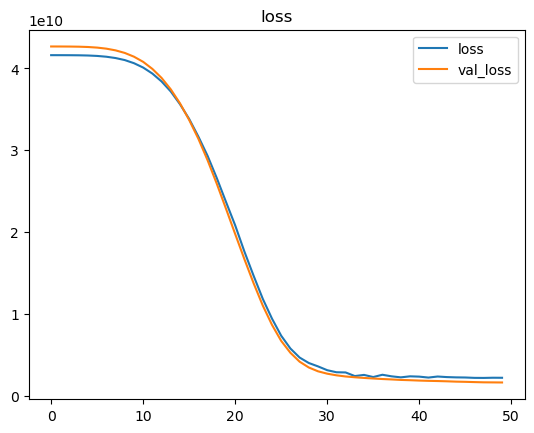

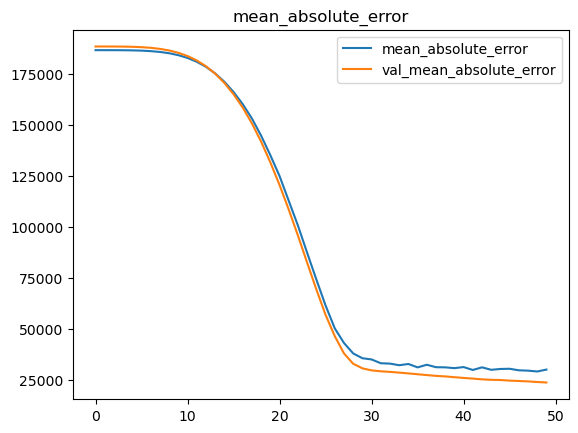

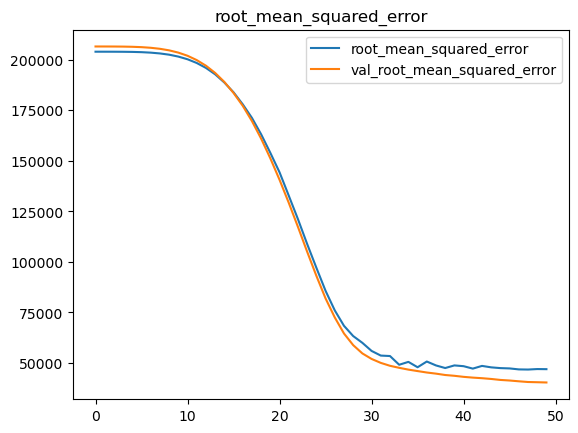

9/9 [==============================] - 0s 748us/step
Final MAE: 23818.83
Final RMSE: 40292.88
Final R2: 0.77


In [63]:
input_dim = X_train_proc.shape[1]

model = Sequential()

model.add(Dense(30, input_dim=input_dim, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(15, activation='relu'))
model.add(Dense(5, activation='relu'))
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='adam', metrics=[metrics.MeanAbsoluteError(), metrics.RootMeanSquaredError()])

history = model.fit(X_train_proc, y_train, validation_data=(X_test_proc, y_test), epochs=50, verbose=0)
plot_history(history)
y_pred = model.predict(X_test_proc)
evaulate(y_pred, y_test)

## Second Model

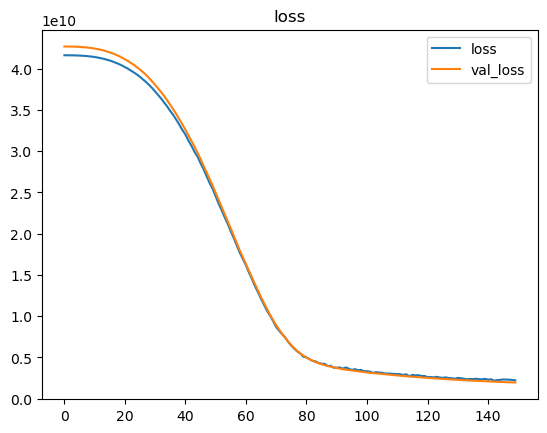

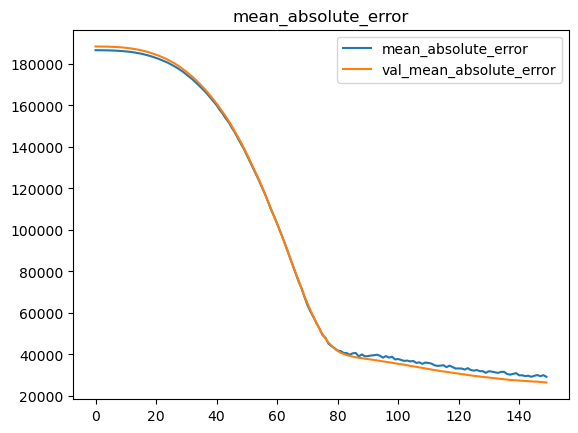

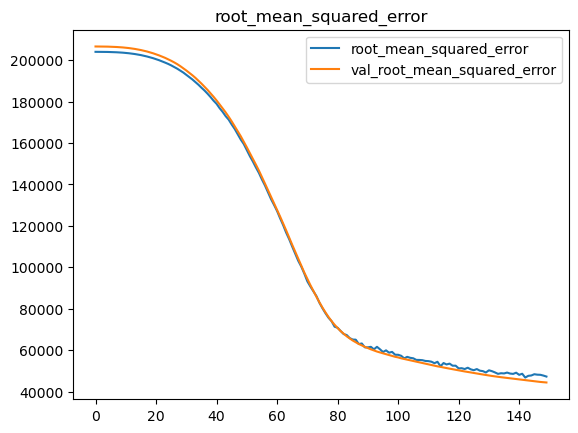

9/9 [==============================] - 0s 935us/step
Final MAE: 26494.62
Final RMSE: 44360.46
Final R2: 0.73


In [64]:
input_dim = X_train_proc.shape[1]

model = Sequential()

model.add(Dense(60, input_dim=input_dim, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(40, activation='relu'))
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='adamax', metrics=[metrics.MeanAbsoluteError(), metrics.RootMeanSquaredError()])
early_stopping = EarlyStopping(patience=5)

history = model.fit(X_train_proc, y_train, validation_data=(X_test_proc, y_test), epochs=150, verbose=0)
plot_history(history)
y_pred = model.predict(X_test_proc)
evaulate(y_pred, y_test)

## Model 3

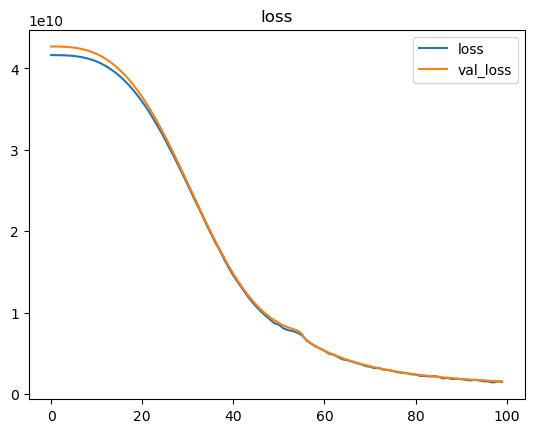

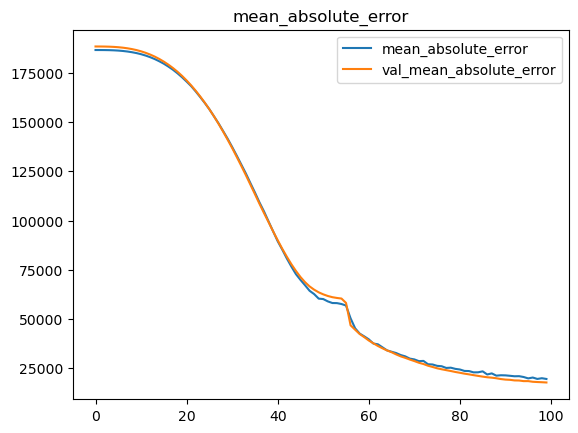

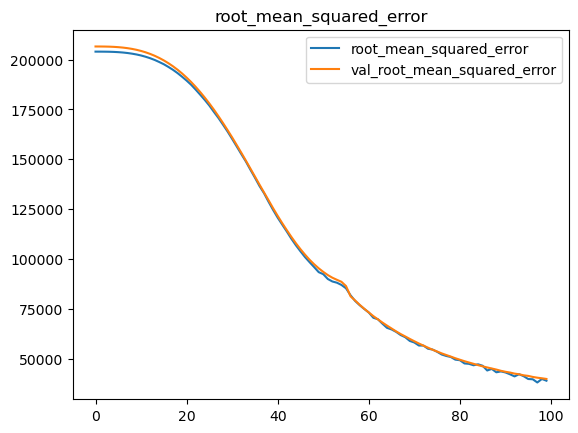

9/9 [==============================] - 0s 873us/step
Final MAE: 17743.22
Final RMSE: 39850.96
Final R2: 0.78


In [65]:
input_dim = X_train_proc.shape[1]

model = Sequential()

model.add(Dense(80, input_dim=input_dim, activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(40, activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='adam', metrics=[metrics.MeanAbsoluteError(), metrics.RootMeanSquaredError()])
early_stopping = EarlyStopping(patience=5)

history = model.fit(X_train_proc, y_train, validation_data=(X_test_proc, y_test), epochs=100, verbose=0)
plot_history(history)
y_pred = model.predict(X_test_proc)
evaulate(y_pred, y_test)

For the final model I would choose model 3 because of its r2 score being the highest but also the errors were the lowest too. Some more adjusting and making tweaks and this would be a good model for real world practice.